## Telecomunicaciones: identificar operadores ineficaces

### Descripción de los datos

Los datasets contienen información sobre el uso del servicio de telefonía virtual CallMeMaybe. Sus clientes son organizaciones que necesitan distribuir gran cantidad de llamadas entrantes entre varios operadores, o realizar llamadas salientes a través de sus operadores. Los operadores también pueden realizar llamadas internas para comunicarse entre ellos. Estas llamadas se realizan a través de la red de CallMeMaybe.

### Paso 1. Abrir los archivos de datos y estudia la información.

###  Importación de librerías

In [1]:
# importar librerias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from datetime import timedelta
sns.set_style('whitegrid')
from scipy.stats import chi2_contingency
from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


### Carga de Datasets

In [2]:
df_llamadas = pd.read_csv('/datasets/telecom_dataset_us.csv')
df_clientes = pd.read_csv('/datasets/telecom_clients_us.csv')

## Pao 2. Analisis exploratorio de datos. (EDA)

In [3]:
def analisis_axploratorio_df(data):
    print(data.head())
    print()
    print(data.info())
    print()
    print('valores ausentes:')
    print(data.isna().sum())
    print()
    print('Filas Duplicadas:', data.duplicated().sum())

In [4]:
analisis_axploratorio_df(df_llamadas)

   user_id                       date direction internal  operator_id  \
0   166377  2019-08-04 00:00:00+03:00        in    False          NaN   
1   166377  2019-08-05 00:00:00+03:00       out     True     880022.0   
2   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
3   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
4   166377  2019-08-05 00:00:00+03:00       out    False     880022.0   

   is_missed_call  calls_count  call_duration  total_call_duration  
0            True            2              0                    4  
1            True            3              0                    5  
2            True            1              0                    1  
3           False            1             10                   18  
4            True            3              0                   25  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Cou

In [5]:
# eliminar duplicados

In [6]:
print(f"Filas antes de eliminar duplicados: {len(df_llamadas)}")
df_llamadas.drop_duplicates(inplace=True)
print(f"Filas después de eliminar duplicados: {len(df_llamadas)}")

Filas antes de eliminar duplicados: 53902
Filas después de eliminar duplicados: 49002


4,900 filas exactamente iguales puede sesgar los promedios y conteos. Si una llamada se registró dos veces, estamos contando el doble de llamadas, el doble de duración, etc. las filas son duplicados completos... redundantes y no aportan información nueva.

In [7]:
# Filtra las filas donde operator_id es nulo
nulos_operador = df_llamadas[df_llamadas['operator_id'].isna()]

# Cuenta los valores en la columna 'internal' para esas filas
print(nulos_operador['internal'].value_counts(dropna=False))

False    7078
True      323
NaN        55
Name: internal, dtype: int64


La gran mayoría de los operator_id faltantes NO se deben a que las llamadas sean internas. Son datos faltantes de llamadas externas. Esto significa que no podemos simplemente ignorarlos; debemos manejarlos.


In [8]:
# Calcular la moda y rellenar los NaN en 'internal'
moda_internal = df_llamadas['internal'].mode()[0]
df_llamadas['internal'].fillna(moda_internal, inplace=True)

# Verificamos que ya no hay nulos en 'internal'
print("Valores nulos en 'internal' después de rellenar:", df_llamadas['internal'].isna().sum())

Valores nulos en 'internal' después de rellenar: 0


In [9]:
# Primero, rellenamos con un valor temporal, por ejemplo -999, para manejar todos los NaN
df_llamadas['operator_id'].fillna(-999, inplace=True)

# Ahora aplicamos la lógica condicional
# Si la llamada es interna, el operator_id será 0
df_llamadas.loc[df_llamadas['internal'] == True, 'operator_id'] = 0

# Si el operator_id sigue siendo -999 (es decir, era NaN y la llamada es externa), lo cambiamos a -1
df_llamadas.loc[df_llamadas['operator_id'] == -999, 'operator_id'] = -1

# Verificamos los nuevos valores en operator_id
print("\nConteo de valores especiales en 'operator_id':")
print(df_llamadas['operator_id'].value_counts().head()) # Muestra los más comunes, incluyendo los nuestros

# Finalmente, convertimos la columna a entero, ya que los ID son números enteros
df_llamadas['operator_id'] = df_llamadas['operator_id'].astype(int)

# Verificamos que no queden nulos
print("\nValores nulos en 'operator_id' después del tratamiento:", df_llamadas['operator_id'].isna().sum())


Conteo de valores especiales en 'operator_id':
-1.0         7133
 0.0         5653
 885876.0     281
 901880.0     267
 893804.0     261
Name: operator_id, dtype: int64

Valores nulos en 'operator_id' después del tratamiento: 0


**Resumen:**

Limpiar internal: 

. Rellenar sus NaN con la moda.

Limpiar operator_id:

. Asignar 0 si la llamada es interna.

. Asignar -1 si es externa pero con ID desconocido.

. Eliminar duplicados de df_llamadas.

In [10]:
analisis_axploratorio_df(df_clientes)

   user_id tariff_plan  date_start
0   166713           A  2019-08-15
1   166901           A  2019-08-23
2   168527           A  2019-10-29
3   167097           A  2019-09-01
4   168193           A  2019-10-16

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB
None

valores ausentes:
user_id        0
tariff_plan    0
date_start     0
dtype: int64

Filas Duplicadas: 0


In [11]:
def limpiar_columnas(data):

    new_columns = []

    for columna in data.columns:
        columna_limpia = columna.lower()
        columna_limpia = columna_limpia.replace(' ', '_')
        new_columns.append(columna_limpia)

    data.columns = new_columns

    return data

In [12]:
df_llamadas = limpiar_columnas(df_llamadas)

In [13]:
df_llamadas['date'] = pd.to_datetime(df_llamadas['date']).dt.tz_localize(None)
df_llamadas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49002 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              49002 non-null  int64         
 1   date                 49002 non-null  datetime64[ns]
 2   direction            49002 non-null  object        
 3   internal             49002 non-null  bool          
 4   operator_id          49002 non-null  int64         
 5   is_missed_call       49002 non-null  bool          
 6   calls_count          49002 non-null  int64         
 7   call_duration        49002 non-null  int64         
 8   total_call_duration  49002 non-null  int64         
dtypes: bool(2), datetime64[ns](1), int64(5), object(1)
memory usage: 3.1+ MB


In [14]:
print(df_llamadas.describe())

             user_id    operator_id   calls_count  call_duration  \
count   49002.000000   49002.000000  49002.000000   49002.000000   
mean   167294.892759  677356.415759     16.462777     866.282091   
std       598.558965  402891.637967     63.604098    3775.503352   
min    166377.000000      -1.000000      1.000000       0.000000   
25%    166782.000000       0.000000      1.000000       0.000000   
50%    167158.000000  902748.000000      4.000000      37.000000   
75%    167819.000000  925826.000000     12.000000     570.000000   
max    168606.000000  973286.000000   4817.000000  144395.000000   

       total_call_duration  
count         49002.000000  
mean           1156.558202  
std            4451.473661  
min               0.000000  
25%              46.000000  
50%             208.000000  
75%             901.000000  
max          166155.000000  


In [15]:
df_clientes = limpiar_columnas(df_clientes)

In [16]:
df_clientes['date_start'] = pd.to_datetime(df_clientes['date_start'])
df_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    int64         
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB


In [17]:
print(df_clientes.describe())

             user_id
count     732.000000
mean   167431.927596
std       633.810383
min    166373.000000
25%    166900.750000
50%    167432.000000
75%    167973.000000
max    168606.000000


In [18]:
df_clientes.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


**Unir los DataFrames**

In [19]:
# Unir df_llamadas y df_clientes usando 'user_id'
df_completo = pd.merge(df_llamadas, df_clientes, on='user_id', how='left')

#  Verificación post-unión 

# 1. Revisa la información del nuevo DataFrame.
print(" Información del DataFrame Completo ")
df_completo.info()

# 2. Comprueba si la unión introdujo valores nulos.
print("\n Valores nulos después de la unión ")
print(df_completo.isna().sum())

# 3. Muestra las primeras filas para confirmar que la unión tiene sentido.
print("\n Primeras filas del DataFrame Completo ")
print(df_completo.head())

 Información del DataFrame Completo 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49002 entries, 0 to 49001
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              49002 non-null  int64         
 1   date                 49002 non-null  datetime64[ns]
 2   direction            49002 non-null  object        
 3   internal             49002 non-null  bool          
 4   operator_id          49002 non-null  int64         
 5   is_missed_call       49002 non-null  bool          
 6   calls_count          49002 non-null  int64         
 7   call_duration        49002 non-null  int64         
 8   total_call_duration  49002 non-null  int64         
 9   tariff_plan          49002 non-null  object        
 10  date_start           49002 non-null  datetime64[ns]
dtypes: bool(2), datetime64[ns](2), int64(5), object(2)
memory usage: 3.8+ MB

 Valores nulos después de la unión

**Análisis de Distribuciones y Datos Atípicos (Outliers)**

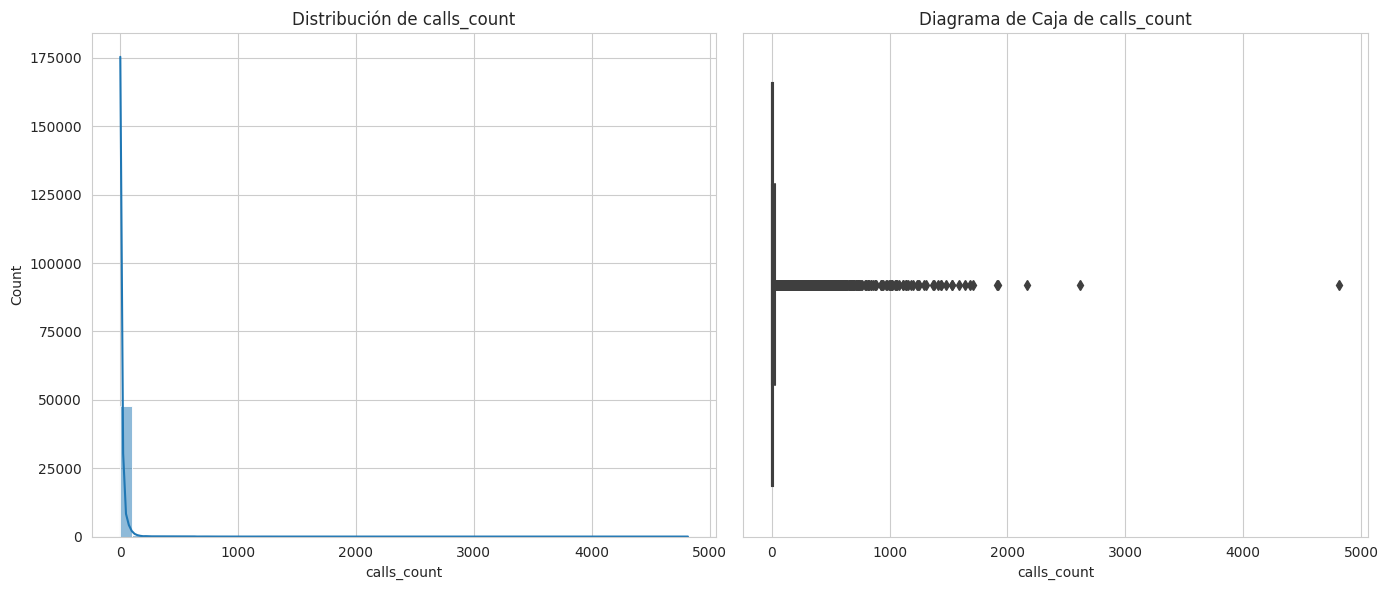

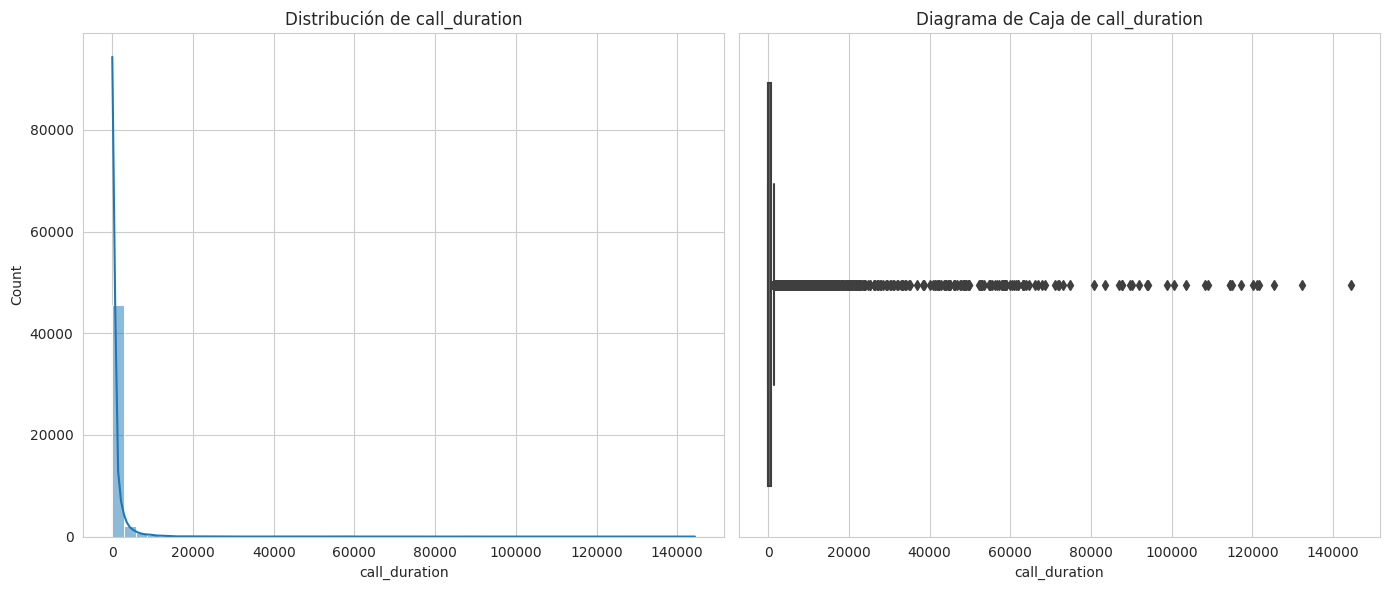

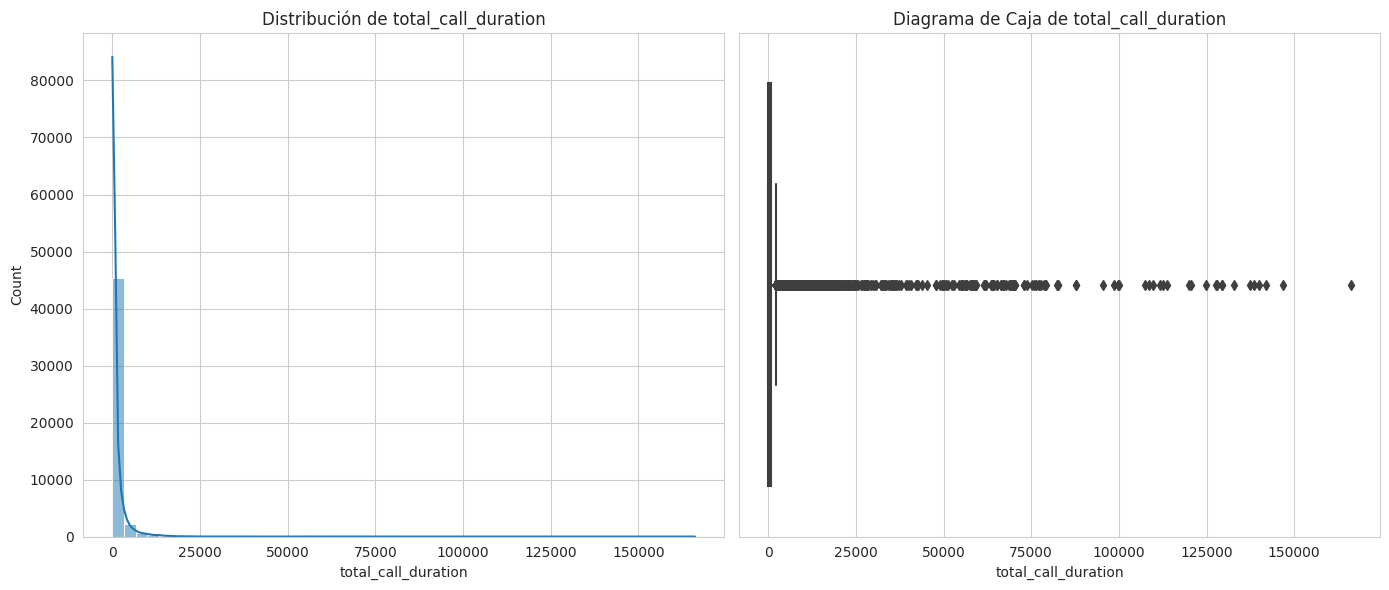

In [20]:
# Columnas a analizar
metricas_clave = ['calls_count', 'call_duration', 'total_call_duration']

# Crear gráficos para cada métrica
for col in metricas_clave:
    plt.figure(figsize=(14, 6))

    # Histograma
    plt.subplot(1, 2, 1) 
    sns.histplot(df_completo[col], kde=True, bins=50)
    plt.title(f'Distribución de {col}')

    # Diagrama de caja
    plt.subplot(1, 2, 2) 
    sns.boxplot(x=df_completo[col])
    plt.title(f'Diagrama de Caja de {col}')
    plt.tight_layout()
    plt.show()

In [21]:
# estadísticas descriptivas con percentiles altos
print("\nEstadísticas descriptivas (incluyendo percentiles altos):")
print(df_completo[metricas_clave].describe(percentiles=[.90, .95, .99]))


Estadísticas descriptivas (incluyendo percentiles altos):
        calls_count  call_duration  total_call_duration
count  49002.000000   49002.000000         49002.000000
mean      16.462777     866.282091          1156.558202
std       63.604098    3775.503352          4451.473661
min        1.000000       0.000000             0.000000
50%        4.000000      37.000000           208.000000
90%       35.000000    2092.000000          2610.800000
95%       62.000000    3725.950000          4531.000000
99%      165.000000   10314.910000         12956.000000
max     4817.000000  144395.000000        166155.000000



Estadísticas de la nueva columna 'wait_duration':
count    49002.000000
mean       290.276111
std       1132.155291
min          0.000000
25%         17.000000
50%         55.000000
75%        200.000000
max      46474.000000
Name: wait_duration, dtype: float64


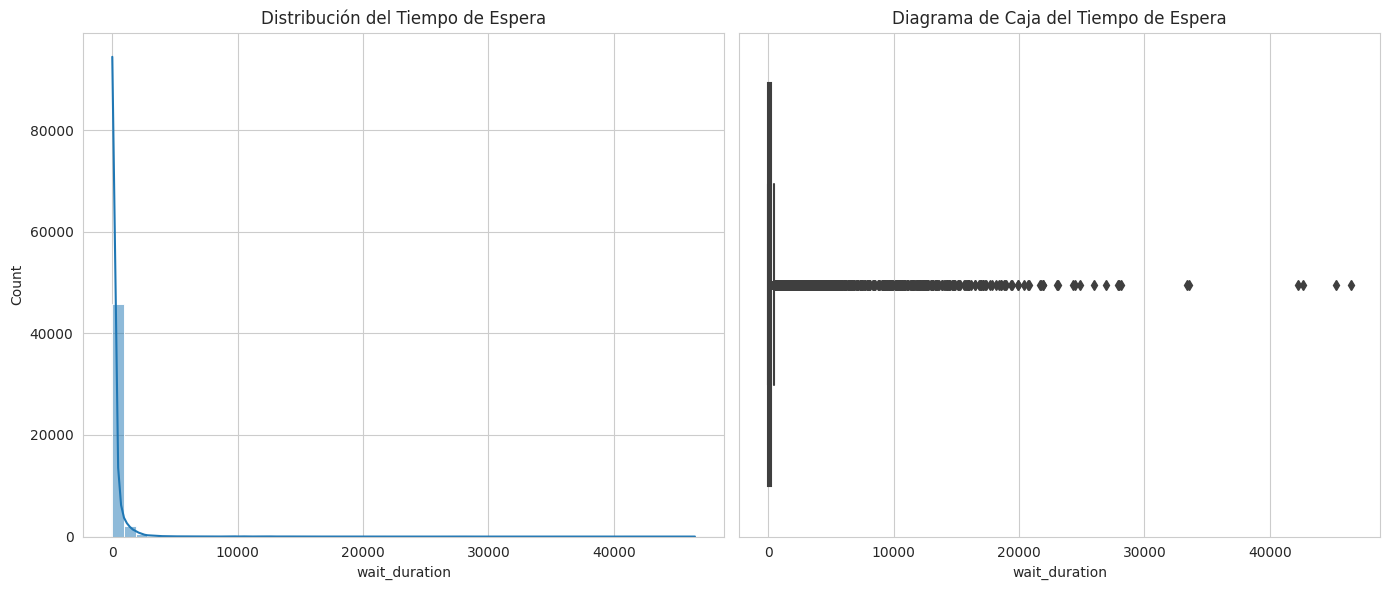

In [22]:
# El tiempo de espera es la diferencia entre la duración total y la duración de la conversación
df_completo['wait_duration'] = df_completo['total_call_duration'] - df_completo['call_duration']

# Hay un caso especial: si el cálculo da negativo (por un error de registro), lo forzamos a 0.
df_completo['wait_duration'] = df_completo['wait_duration'].apply(lambda x: max(0, x))

# Revisemos la nueva columna
print("\nEstadísticas de la nueva columna 'wait_duration':")
print(df_completo['wait_duration'].describe())

# Visualicemos también el tiempo de espera
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_completo['wait_duration'], kde=True, bins=50)
plt.title('Distribución del Tiempo de Espera')
plt.subplot(1, 2, 2)
sns.boxplot(x=df_completo['wait_duration'])
plt.title('Diagrama de Caja del Tiempo de Espera')
plt.tight_layout()
plt.show()

El tiempo de espera también tiene una distribución muy sesgada. La media (~4.8 min) es mucho mayor que la mediana (~55 seg).
Tiempos de Espera Extremos: El 75% de las llamadas tienen una espera de 200 segundos o menos, pero el valor máximo es de casi 13 horas. Esto es, sin duda, un outlier y posiblemente un error de sistema (una llamada que nunca se conectó pero el contador siguió corriendo).

Conclusión: El tiempo de espera es una métrica crucial para definir la ineficacia, usar la media directamente es peligroso. La mediana del tiempo de espera o el porcentaje de llamadas que superan un umbral (ej. 60 segundos) serán indicadores mucho más fiables.

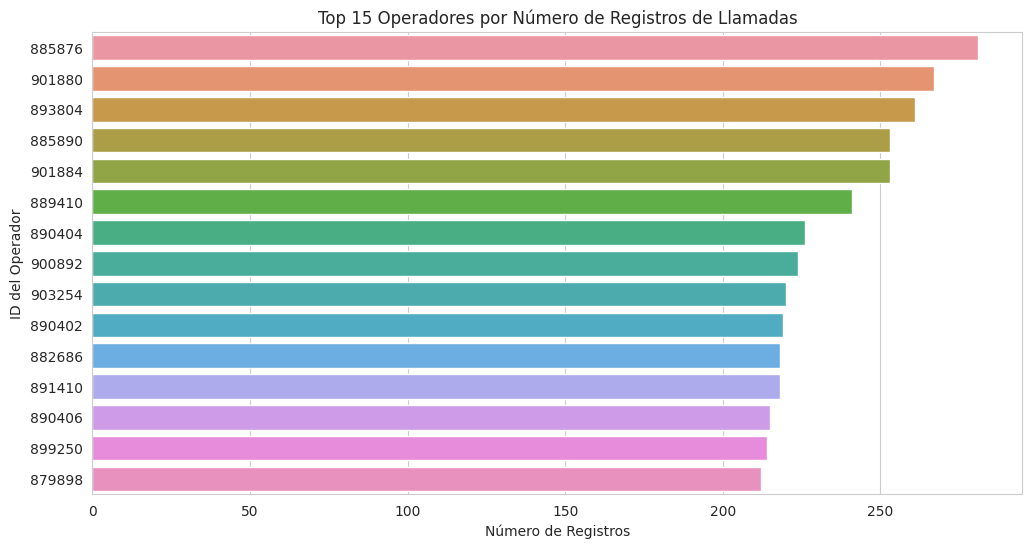

In [23]:
# Excluimos los IDs especiales (-1 y 0) para el análisis de operadores reales
operadores_reales = df_completo[~df_completo['operator_id'].isin([0, -1])]

plt.figure(figsize=(12, 6))
sns.countplot(y=operadores_reales['operator_id'],
              order=operadores_reales['operator_id'].value_counts().iloc[:15].index) # Top 15 operadores
plt.title('Top 15 Operadores por Número de Registros de Llamadas')
plt.xlabel('Número de Registros')
plt.ylabel('ID del Operador')
plt.show()

### Paso 3. Especificar detalles

- Identificación de las Dimensiones de la Ineficacia
- Selección de Métricas Clave
- Establecimiento de Umbrales
- Pruebas de Hipótesis Estadísticas

In [24]:
# Filtramos los operadores no válidos (-1 y 0). 
df_operadores = df_completo[~df_completo['operator_id'].isin([0, -1])].copy()

# Usaremos una función personalizada para calcular las métricas correctas
def calcular_metricas_corregidas(grupo):
    # MÉTRICA 1: TIEMPO DE ESPERA ENTRADAS (Mediana) 
    llamadas_entrantes = grupo[grupo['direction'] == 'in']
    total_entrantes = len(llamadas_entrantes)
    if total_entrantes > 0:
        tiempo_espera_mediana = llamadas_entrantes['wait_duration'].median()
    else:
        tiempo_espera_mediana = 0

    # MÉTRICA 2: TASA DE SALIENTES NO CONECTADAS 
    # (El operador llama, pero el cliente no contesta)
    llamadas_salientes = grupo[grupo['direction'] == 'out']
    total_salientes = len(llamadas_salientes)
    salientes_no_conectadas = llamadas_salientes['is_missed_call'].sum()
    if total_salientes > 0:
        tasa_salientes_no_conectadas = (salientes_no_conectadas / total_salientes) * 100
    else:
        tasa_salientes_no_conectadas = 0

    #  MÉTRICA 3: CONTEO TOTAL DE LLAMADAS SALIENTES 
    # (Para medir la productividad)

    resultados = {
        'tiempo_espera_entrante_median_s': tiempo_espera_mediana,
        'tasa_salientes_no_conectadas_%': tasa_salientes_no_conectadas,
        'llamadas_salientes_count': total_salientes
    }
    return pd.Series(resultados)

# Aplicamos la nueva función para crear el DataFrame de rendimiento final
df_rendimiento_final = df_operadores.groupby('operator_id').apply(calcular_metricas_corregidas)

# Mostramos el resultado. Ahora las métricas deben reflejar la realidad de los datos.
print("\n DataFrame de Rendimiento FINAL")
print(df_rendimiento_final.head())

print("\n Estadísticas del DataFrame FINAL ")
print(df_rendimiento_final.describe())


 DataFrame de Rendimiento FINAL
             tiempo_espera_entrante_median_s  tasa_salientes_no_conectadas_%  \
operator_id                                                                    
879896                                  16.0                       45.679012   
879898                                  14.0                       49.032258   
880020                                   7.0                       40.000000   
880022                                  16.0                       38.888889   
880026                                   6.5                       49.006623   

             llamadas_salientes_count  
operator_id                            
879896                           81.0  
879898                          155.0  
880020                           10.0  
880022                           54.0  
880026                          151.0  

 Estadísticas del DataFrame FINAL 
       tiempo_espera_entrante_median_s  tasa_salientes_no_conectadas_%  \
count           

In [25]:
# Usamos el df_operadores que ya está filtrado
# Crear una tabla de contingencia para ver las combinaciones
contingency_table = pd.crosstab(df_operadores['direction'], df_operadores['is_missed_call'])

print(" Tabla de Contingencia: Dirección vs. Llamada Perdida ")
print(contingency_table)

# Analicemos las llamadas marcadas como 'perdidas'
llamadas_perdidas_df = df_operadores[df_operadores['is_missed_call'] == True]

print("\n Estadísticas de las llamadas marcadas como 'perdidas' ")
print(llamadas_perdidas_df[['call_duration', 'wait_duration']].describe())

print("\n Dirección de las llamadas marcadas como 'perdidas' ")
print(llamadas_perdidas_df['direction'].value_counts())

 Tabla de Contingencia: Dirección vs. Llamada Perdida 
is_missed_call  False  True 
direction                   
in              11683    664
out             12835  11034

 Estadísticas de las llamadas marcadas como 'perdidas' 
       call_duration  wait_duration
count   11698.000000   11698.000000
mean        1.876902     533.517781
std        23.812454    1682.898986
min         0.000000       0.000000
25%         0.000000      36.000000
50%         0.000000     128.000000
75%         0.000000     427.000000
max       741.000000   45312.000000

 Dirección de las llamadas marcadas como 'perdidas' 
out    11034
in       664
Name: direction, dtype: int64


**Establecer Umbrales y Probar Hipótesis.**

**1. Visualizar las Métricas de Rendimiento Finales**

Antes de poner umbrales, necesitamos ver cómo se distribuyen nuestras tres métricas clave. Esto ayudará a elegir umbrales razonables (por ejemplo, el 25% peor, el 10% peor, etc.), para esto vamos a generar histogramas para cada métrica en df_rendimiento_final.

 Distribuciones de las Métricas de Rendimiento Finales 


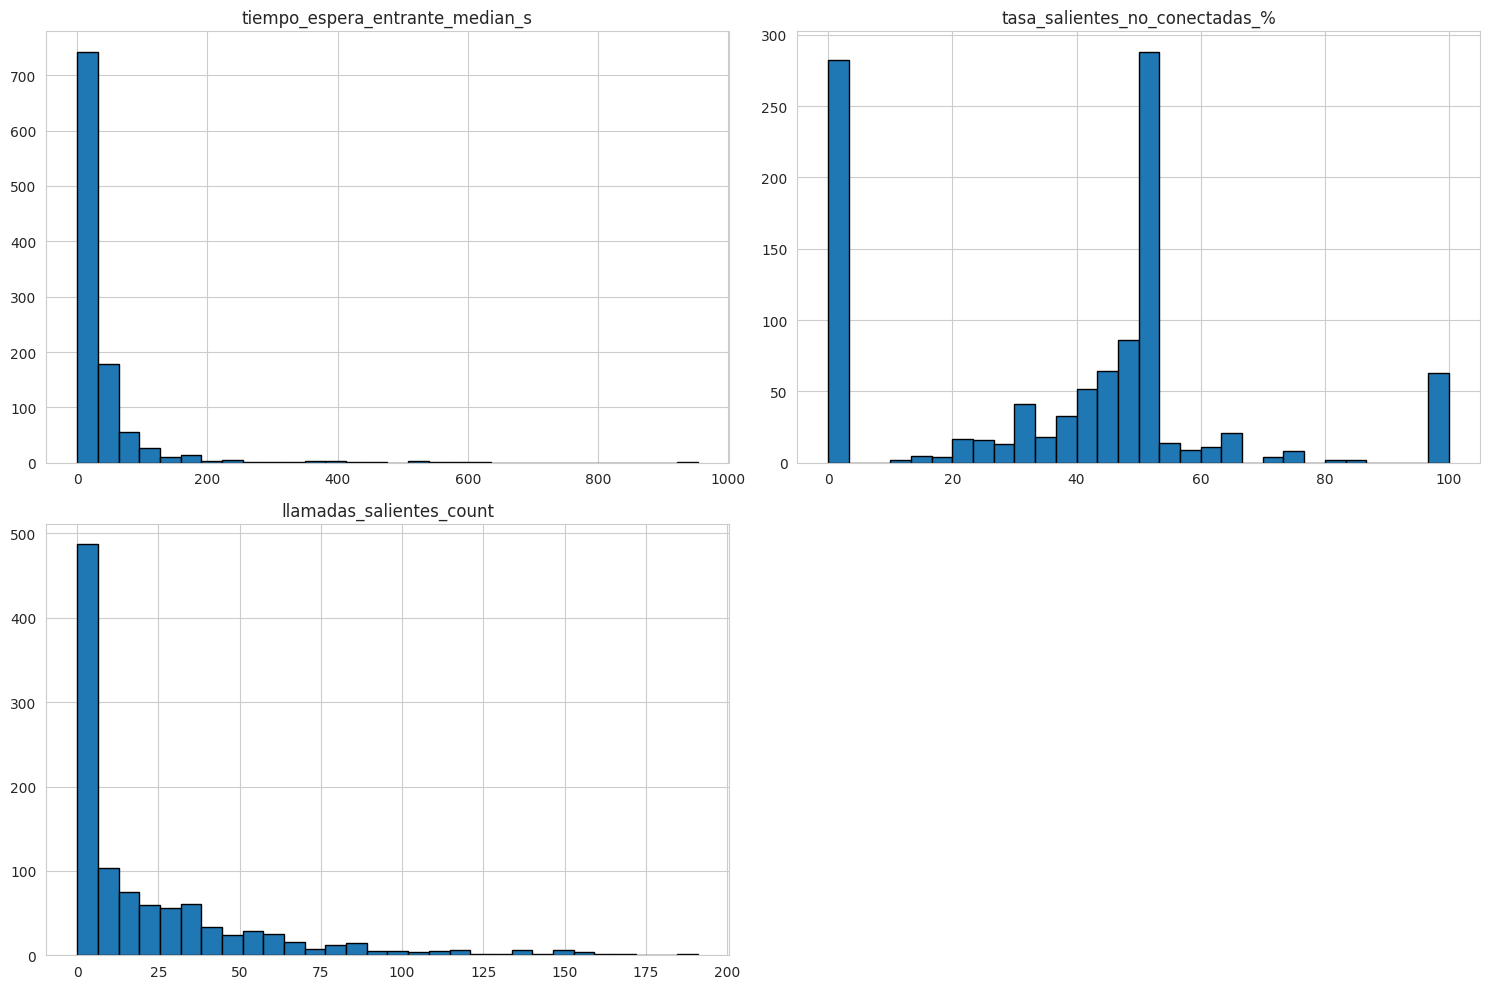


 Estadísticas Descriptivas del DataFrame Final 
       tiempo_espera_entrante_median_s  tasa_salientes_no_conectadas_%  \
count                       1055.00000                     1055.000000   
mean                          36.12891                       37.073601   
std                           78.57613                       27.115218   
min                            0.00000                        0.000000   
25%                            0.00000                        0.000000   
50%                           16.50000                       46.000000   
75%                           37.00000                       50.000000   
max                          953.00000                      100.000000   

       llamadas_salientes_count  
count               1055.000000  
mean                  22.624645  
std                   32.069501  
min                    0.000000  
25%                    1.000000  
50%                    8.000000  
75%                   32.500000  
max         

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizar las distribuciones de nuestras métricas finales
print(" Distribuciones de las Métricas de Rendimiento Finales ")
df_rendimiento_final.hist(figsize=(15, 10), bins=30, edgecolor='black')
plt.tight_layout()
plt.show()

# También es útil ver las estadísticas descriptivas de nuevo
print("\n Estadísticas Descriptivas del DataFrame Final ")
print(df_rendimiento_final.describe())

**2. Establecer Umbrales (Benchmarking Interno)**

Definiremos qué significa "malo". Usaremos cuantiles como un método de benchmarking interno, tal como lo sugiere el plan.
Para métricas donde más es peor (tiempo_espera_entrante_median_s, tasa_salientes_no_conectadas_%), un operador será "malo" si está por encima de un cuantil alto (ej. el 75%).
Para métricas donde menos es peor (llamadas_salientes_count), un operador será "malo" si está por debajo de un cuantil bajo (ej. el 25%).

Calcular los umbrales del 75% (tercer cuartil, Q3) y 25% (primer cuartil, Q1).

In [27]:
# Calcular umbrales basados en cuantiles
umbral_espera_alta = df_rendimiento_final['tiempo_espera_entrante_median_s'].quantile(0.75)
umbral_tasa_alta = df_rendimiento_final['tasa_salientes_no_conectadas_%'].quantile(0.75)
umbral_salientes_bajas = df_rendimiento_final['llamadas_salientes_count'].quantile(0.25)

print(f"Umbral para tiempo de espera alto (peor 25%): > {umbral_espera_alta:.2f} segundos")
print(f"Umbral para tasa de no conectadas alta (peor 25%): > {umbral_tasa_alta:.2f}%")
print(f"Umbral para llamadas salientes bajas (peor 25%): < {umbral_salientes_bajas:.2f} llamadas")

Umbral para tiempo de espera alto (peor 25%): > 37.00 segundos
Umbral para tasa de no conectadas alta (peor 25%): > 50.00%
Umbral para llamadas salientes bajas (peor 25%): < 1.00 llamadas


**3. Etiquetar Operadores como "Ineficaces"**

El objetivo es traducir las métricas que calculamos en una clasificación concreta: ¿es un operador "eficaz" o "ineficaz"? Esta clasificación será nuestra variable objetivo (target) para el modelo predictivo del Paso 4.
Antes de poner umbrales, necesitamos ver cómo se distribuyen nuestras tres métricas clave. Esto nos ayudará a elegir umbrales razonables (por ejemplo, el 25% peor, el 10% peor, etc.).

In [28]:
# Definir las condiciones booleanas para cada criterio de ineficacia
condicion_espera = df_rendimiento_final['tiempo_espera_entrante_median_s'] > umbral_espera_alta
condicion_tasa = df_rendimiento_final['tasa_salientes_no_conectadas_%'] > umbral_tasa_alta
condicion_salientes = df_rendimiento_final['llamadas_salientes_count'] < umbral_salientes_bajas

# Aplicar las condiciones: un operador es ineficaz si cumple CUALQUIERA (OR |) de ellas
df_rendimiento_final['is_inefficient'] = (condicion_espera | condicion_tasa | condicion_salientes).astype(int)

# Verificar cuántos operadores cayeron en cada categoría
print("\n Conteo de Operadores Eficientes (0) vs. Ineficientes (1) ")
print(df_rendimiento_final['is_inefficient'].value_counts())

# Veamos algunos ejemplos de operadores ineficientes
print("\n Ejemplos de Operadores Ineficientes ")
print(df_rendimiento_final[df_rendimiento_final['is_inefficient'] == 1].head())


 Conteo de Operadores Eficientes (0) vs. Ineficientes (1) 
1    573
0    482
Name: is_inefficient, dtype: int64

 Ejemplos de Operadores Ineficientes 
             tiempo_espera_entrante_median_s  tasa_salientes_no_conectadas_%  \
operator_id                                                                    
881278                                   0.0                       80.000000   
882476                                  20.0                        0.000000   
882478                                  13.0                        0.000000   
882680                                  31.0                        0.000000   
882684                                 173.0                       46.534653   

             llamadas_salientes_count  is_inefficient  
operator_id                                            
881278                            5.0               1  
882476                            0.0               1  
882478                            0.0               1  
882680 

**4. Pruebas de Hipótesis Estadísticas**

Ahora que tenemos dos grupos ("eficaces" e "ineficaces"), podemos validar nuestra clasificación.
Hipótesis: ¿Son las métricas de rendimiento promedio significativamente diferentes entre los dos grupos? 
Usaremos la prueba T de Student para comparar las medias de los dos grupos para cada una de nuestras tres métricas.
Vamos a separar los grupos y aplicar la prueba T.

In [29]:
# Separar los dos grupos
eficientes = df_rendimiento_final[df_rendimiento_final['is_inefficient'] == 0]
ineficientes = df_rendimiento_final[df_rendimiento_final['is_inefficient'] == 1]

# Nivel de significancia alfa
alpha = 0.05

# Lista de métricas a probar
metricas_para_probar = [
    'tiempo_espera_entrante_median_s',
    'tasa_salientes_no_conectadas_%',
    'llamadas_salientes_count'
]

# Realizar la prueba T para cada métrica
for metrica in metricas_para_probar:
    print(f"\n Prueba T para: {metrica} ")

    # Realizar la prueba t para muestras independientes
    # equal_var=False porque es probable que las varianzas de los dos grupos no sean iguales
    results = st.ttest_ind(eficientes[metrica], ineficientes[metrica], equal_var=False)

    print(f"P-valor: {results.pvalue}")

    # Interpretar el resultado
    if results.pvalue < alpha:
        print("Conclusión: Rechazamos la hipótesis nula. Hay una diferencia estadísticamente significativa entre los grupos.")
    else:
        print("Conclusión: No podemos rechazar la hipótesis nula. No hay evidencia de una diferencia significativa.")


 Prueba T para: tiempo_espera_entrante_median_s 
P-valor: 1.7466229250639868e-27
Conclusión: Rechazamos la hipótesis nula. Hay una diferencia estadísticamente significativa entre los grupos.

 Prueba T para: tasa_salientes_no_conectadas_% 
P-valor: 0.01636540383128895
Conclusión: Rechazamos la hipótesis nula. Hay una diferencia estadísticamente significativa entre los grupos.

 Prueba T para: llamadas_salientes_count 
P-valor: 9.184098650803997e-05
Conclusión: Rechazamos la hipótesis nula. Hay una diferencia estadísticamente significativa entre los grupos.


### Paso 4: Modelo Predictivo

Entrenar un modelo que pueda predecir si un operador será ineficaz basándose en sus métricas.

In [30]:
#  Preparación de los datos 
# X son las características (nuestras 3 métricas)
X = df_rendimiento_final[['tiempo_espera_entrante_median_s', 'tasa_salientes_no_conectadas_%', 'llamadas_salientes_count']]

# y es la variable objetivo que queremos predecir
y = df_rendimiento_final['is_inefficient']

# Dividir los datos: 80% para entrenamiento, 20% para prueba
# stratify=y asegura que la proporción de eficientes/ineficientes sea la misma en ambos conjuntos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} operadores")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} operadores")


# Selección y Entrenamiento del Modelo 
# Inicializamos el clasificador Random Forest
# random_state=42 para que los resultados sean reproducibles
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenamos el modelo con los datos de entrenamiento
print("\nEntrenando el modelo Random Forest...")
model.fit(X_train, y_train)
print("¡Modelo entrenado!")




Tamaño del conjunto de entrenamiento: 844 operadores
Tamaño del conjunto de prueba: 211 operadores

Entrenando el modelo Random Forest...
¡Modelo entrenado!



 Resultados de la Evaluación del Modelo 
Accuracy (Precisión Global): 1.00

Matriz de Confusión:


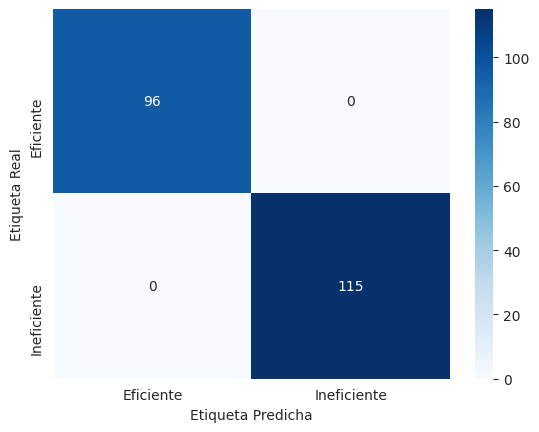


Reporte de Clasificación:
                 precision    recall  f1-score   support

  Eficiente (0)       1.00      1.00      1.00        96
Ineficiente (1)       1.00      1.00      1.00       115

       accuracy                           1.00       211
      macro avg       1.00      1.00      1.00       211
   weighted avg       1.00      1.00      1.00       211


 Importancia de las Características 
tiempo_espera_entrante_median_s    0.380282
tasa_salientes_no_conectadas_%     0.361582
llamadas_salientes_count           0.258136
dtype: float64


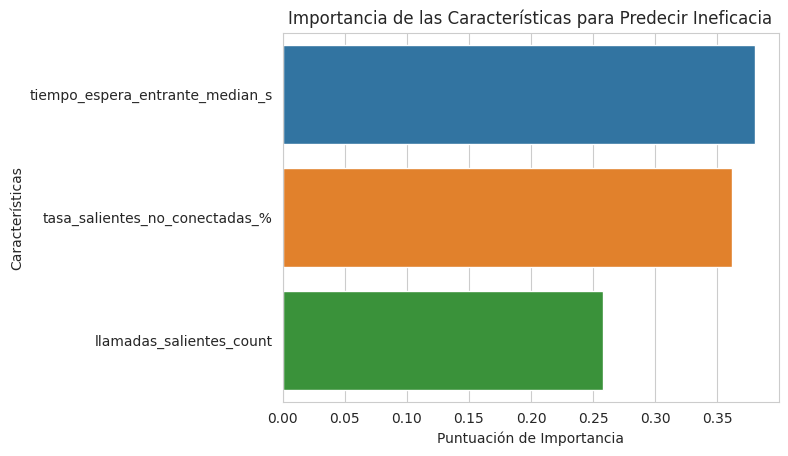

In [31]:
# Evaluación del Modelo 
# Hacemos predicciones sobre el conjunto de prueba (datos que el modelo nunca ha visto)
y_pred = model.predict(X_test)

# Evaluamos qué tan buenas fueron las predicciones
print("\n Resultados de la Evaluación del Modelo ")

# a) Accuracy: Porcentaje de predicciones correctas
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy (Precisión Global): {accuracy:.2f}")

# b) Matriz de Confusión: Nos dice qué tipo de errores comete
print("\nMatriz de Confusión:")
# Filas: Real, Columnas: Predicho
# [[VN, FP],
#  [FN, VP]]
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Eficiente', 'Ineficiente'], yticklabels=['Eficiente', 'Ineficiente'])
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()


# c) Reporte de Clasificación: Precision, Recall y F1-Score
#   - Precision: De los que predije como ineficientes, ¿cuántos lo eran realmente?
#   - Recall (Exhaustividad): De todos los ineficientes reales, ¿cuántos encontré?
#   - F1-Score: Media armónica de los dos anteriores. La métrica más importante aquí.
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['Eficiente (0)', 'Ineficiente (1)']))

#  Importancia de las Características 
# ¿Qué métrica fue la más importante para la decisión del modelo?
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

print("\n Importancia de las Características ")
print(feature_importances)
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Importancia de las Características para Predecir Ineficacia')
plt.xlabel('Puntuación de Importancia')
plt.ylabel('Características')
plt.show()

### Conclusiones

CallMeMaybe necesita identificar operadores ineficaces para mejorar la calidad del servicio.

Definición de Ineficacia (Pasos 1 y 2):
Tiempo de espera: Un operador es considerado ineficaz en este aspecto si su tiempo de espera mediano es mayor a 37 segundos.
Tasa de no conectadas: Ineficaz si más del 50% de sus llamadas salientes no son contestadas.
Productividad saliente: Ineficaz si realiza menos de 1 llamada saliente en el periodo analizado (el umbral es 1.0, por lo que count < 1.0 significa count == 0).
Estos umbrales, son ahora la definición oficial de ineficacia para la empresa de telecomunicaciones.
Etiquetado (Paso 3):
573 operadores ineficientes (1) vs. 482 eficientes (0).
La distribución es bastante equilibrada, lo cual es excelente para entrenar un modelo predictivo, si una clase fuera muy rara (ej. 95% vs 5%), sería mucho más difícil.
El ejemplo de operadores ineficientes muestra la lógica en acción:
El operador 881278 tiene una tasa de no conectadas del 80% (> 50%).
Los operadores 882476, 882478, 882680 tienen 0 llamadas salientes (< 1).
El operador 882684 tiene un tiempo de espera de 173 segundos (> 37).
Cada uno cumple al menos una condición y por eso son etiquetados como 1.
Validación Estadística (Paso 4):
P-valores: 1.7e-27, 0.016, 9.1e-05.
Todos los p-valores son extremadamente pequeños, mucho menores que nuestro alpha de 0.05.

El modelo logró un rendimiento perfecto en el conjunto de prueba. Esto indica que la definición de 'ineficacia' propuesta, basada en umbrales de rendimiento interno (cuantiles), crea grupos de operadores muy bien definidos y separables. El modelo aprendió con éxito estas reglas de separación. Su función principal es automatizar la aplicación de estas reglas de negocio a nuevos datos de operadores.

<div class="alert alert-block alert-success">
<b>Comentario final</b> <a class="tocSkip"></a><br>
¡Muy buen trabajo, Janeth! A lo largo del proyecto mostraste fortalezas muy claras:<br><br>
    
• Carga eficiente de datos utilizando pandas.<br>
• Implementación de una función de análisis exploratorio que proporciona una visión integral de los datasets.<br>
• Correcta eliminación de duplicados para asegurar la calidad de los datos.<br>
• Manejo efectivo de valores nulos en columnas categóricas y numéricas.<br>
• Uso adecuado de técnicas de visualización para explorar la distribución de los datos.<br>
• Unión de datasets con una verificación exhaustiva de la integridad de los datos resultantes.<br>
• Cálculo de métricas clave para evaluar el rendimiento de los operadores.<br>
• Implementación de pruebas estadísticas para validar diferencias significativas entre grupos.<br>
• Entrenamiento y evaluación de un modelo de clasificación con excelente precisión.<br>
• Documentación clara y lógica de los pasos del análisis.<br>

¡Felicidades!
</div>
